<a href="https://colab.research.google.com/github/olszewskip/Sign_Language/blob/master/classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The data comes from this repository:
https://github.com/ardamavi/Sign-Language-Digits-Dataset


In [4]:
from tensorflow import test
test.gpu_device_name()

'/device:GPU:0'

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.nasnet import NASNetMobile
from keras.applications.densenet import DenseNet121
from keras.applications.xception import Xception
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [0]:
working_dir = os.path.join("/content/gdrive/My Drive/Colab Notebooks/Sign_Language/")
github_trainval_data = os.path.join(working_dir, "data/ardamavi/Dataset")
github_test_data = os.path.join(working_dir, "data/ardamavi/Dataset_test")
model_checkpoints = os.path.join(working_dir, "models/tmp")

In [8]:
os.listdir(github_trainval_data)

['6', '7', '5', '0', '8', '4', '1', '2', '3', '9']

In [9]:
total_count = 0
for class_ in os.listdir(github_trainval_data):
  from_dir = os.path.join(github_trainval_data, class_)
  whole_count = len(os.listdir(from_dir))
  total_count += whole_count
  print(f"class {class_}: {whole_count} photos")

print(f"{total_count} photos in total")

class 6: 186 photos
class 7: 178 photos
class 5: 187 photos
class 0: 190 photos
class 8: 188 photos
class 4: 186 photos
class 1: 189 photos
class 2: 186 photos
class 3: 187 photos
class 9: 181 photos
1858 photos in total


In [0]:
# # one-time thing: make a separete directory for test-data
# os.mkdir(github_test_data)

In [8]:
# # one-time thing: set a fraction of the data aside for testing
# test_fraction = 0.1

# for class_ in os.listdir(github_trainval_data):
#   from_dir = os.path.join(github_trainval_data, class_)
#   whole_count = len(os.listdir(from_dir))
#   to_dir = os.path.join(github_test_data, class_)
#   os.mkdir(to_dir)
#   for file in os.listdir(from_dir):
#     if np.random.rand() < test_fraction:
#       from_file = os.path.join(from_dir, file)
#       to_file = os.path.join(to_dir, file)
#       os.rename(from_file, to_file)
#   test_count = len(os.listdir(to_dir))
#   print(f"{class_}: {test_count/whole_count} fraction put aside")

6: 0.10144927536231885 fraction put aside
7: 0.13592233009708737 fraction put aside
5: 0.0966183574879227 fraction put aside
0: 0.07317073170731707 fraction put aside
8: 0.09615384615384616 fraction put aside
4: 0.10144927536231885 fraction put aside
1: 0.0825242718446602 fraction put aside
2: 0.0970873786407767 fraction put aside
3: 0.09223300970873786 fraction put aside
9: 0.11274509803921569 fraction put aside


In [10]:
total_count = 0
for class_ in os.listdir(github_test_data):
  from_dir = os.path.join(github_test_data, class_)
  whole_count = len(os.listdir(from_dir))
  total_count += whole_count
  print(f"class {class_}: {whole_count} photos")

print(f"{total_count} photos in total")

class 6: 21 photos
class 7: 28 photos
class 5: 20 photos
class 0: 15 photos
class 8: 20 photos
class 4: 21 photos
class 1: 17 photos
class 2: 20 photos
class 3: 19 photos
class 9: 23 photos
204 photos in total


In [0]:
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE_EPOCHS = 20
LR = 0.0004

### Create the data-generators that will:
* handle loading the data from disk (each class from separate sub-directory),
* handle train-validation split (from a single directory of sub-directories),
* resclae RGB values by 1/255,
* alternatively apply data augmentation

In [0]:
def prepare_data_gens(image_dim):

  trainval_gen = ImageDataGenerator(rescale=1/255,
                                    validation_split=0.1/0.8)

  trainval_gen_augment = ImageDataGenerator(rescale=1/255,
                                            validation_split=0.1/0.8,
                                            rotation_range=20,
                                            height_shift_range=0.1,
                                            width_shift_range=0.1,
                                            brightness_range=(0.9, 1.1),
                                            zoom_range=0.1
                                           )

  test_gen = ImageDataGenerator(rescale=1/255)

  train_gen = trainval_gen.flow_from_directory(
      github_trainval_data,
      target_size = (image_dim, image_dim),
      batch_size=BATCH_SIZE,
      shuffle=True,
      class_mode='categorical',
      subset='training')

  val_gen = trainval_gen.flow_from_directory(
      github_trainval_data,
      target_size = (image_dim, image_dim),
      batch_size=BATCH_SIZE,
      class_mode='categorical',
      subset='validation')

  train_gen_augment = trainval_gen_augment.flow_from_directory(
      github_trainval_data,
      target_size = (image_dim, image_dim),
      batch_size=BATCH_SIZE,
      shuffle=True,
      class_mode='categorical',
      subset='training')

  val_gen_augment = trainval_gen_augment.flow_from_directory(
      github_trainval_data,
      target_size = (image_dim, image_dim),
      batch_size=BATCH_SIZE,
      class_mode='categorical',
      subset='validation')


  test_gen = trainval_gen.flow_from_directory(
      github_test_data,
      target_size = (image_dim, image_dim),
      batch_size=BATCH_SIZE,
      class_mode='categorical')
  
  return train_gen, val_gen, train_gen_augment, val_gen_augment, test_gen

In [13]:
train_gen, val_gen, train_gen_augment, val_gen_augment, test_gen = prepare_data_gens(100)

Found 1630 images belonging to 10 classes.
Found 228 images belonging to 10 classes.
Found 1630 images belonging to 10 classes.
Found 228 images belonging to 10 classes.
Found 204 images belonging to 10 classes.


In [14]:
train_gen[0][0].shape

(32, 100, 100, 3)

A few random unaugmented images.

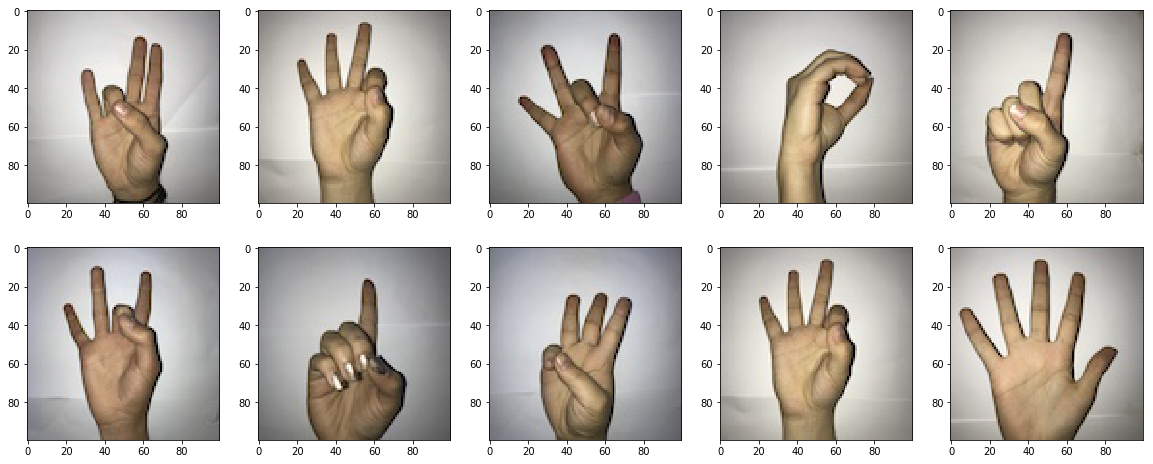

In [15]:
images\
= [train_gen[0][0][np.random.choice(BATCH_SIZE)] for _ in range(10)]
fig, axes = plt.subplots(2, 5, figsize=(20,8))
for img, ax in zip(images, axes.ravel()):
  ax.imshow(img)

A few random augmented images.

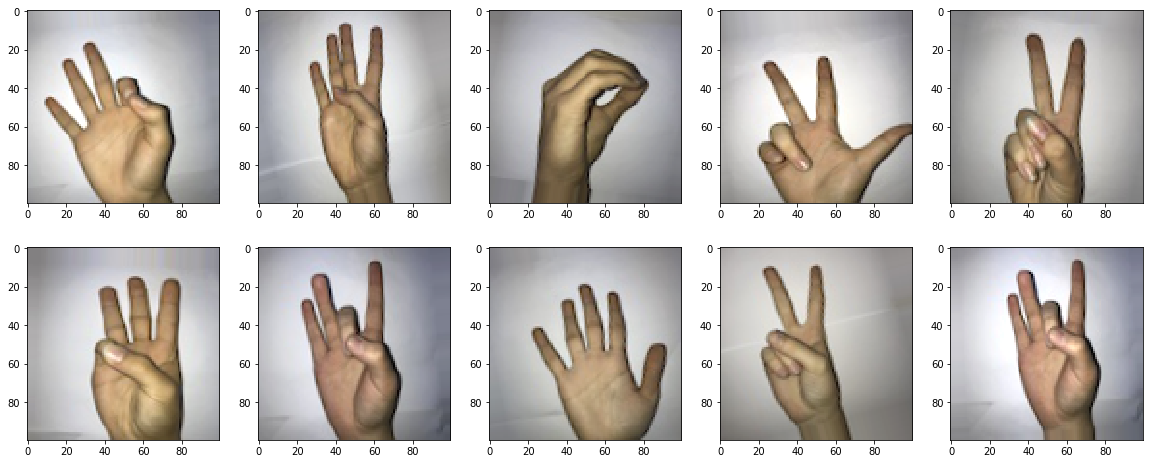

In [16]:
augmented_images\
= [train_gen_augment[0][0][np.random.choice(BATCH_SIZE)] for _ in range(10)]
fig, axes = plt.subplots(2, 5, figsize=(20,8))
for img, ax in zip(augmented_images, axes.ravel()):
  ax.imshow(img)

In [17]:
# Sanity check that all generators see the same number of classes
assert train_gen.num_classes == val_gen.num_classes == train_gen_augment.num_classes == val_gen_augment.num_classes == test_gen.num_classes
num_classes = train_gen.num_classes

# Encoding between directory names and labels
label2class = train_gen.class_indices
label2class

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [0]:
def train_model(model, train_gen, val_gen, weights_file_name, verbosity=1):
  """ Fit the model to training-data-generator.
  Validate on validation-data-generator.
  Save weights of the best model to a file.
  Restore the best weights at the end of training.
  Return history for plotting"""
  
  train_gen.reset()
  val_gen.reset()
  
  callbacks = [ModelCheckpoint(filepath=os.path.join(model_checkpoints,
                                                     weights_file_name),
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True),
               EarlyStopping(monitor='val_loss',
                             min_delta=0,
                             patience=PATIENCE_EPOCHS,
                             verbose=1,
                             restore_best_weights=True)]

  history = model.fit_generator(
      train_gen,
      steps_per_epoch = int(np.ceil(train_gen.samples / BATCH_SIZE)),
      validation_data = val_gen,
      validation_steps = int(np.ceil(val_gen.samples / BATCH_SIZE)),
      epochs = EPOCHS,
      callbacks = callbacks,
      verbose=verbosity
  )
  return history



def plot_history(history):
  """Plot loss and accuracy on two separete plots."""
  
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(loss))

  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, '-', label='Training Accuracy')
  plt.plot(epochs_range, val_acc, '-o', label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, '-', label='Training Loss')
  plt.plot(epochs_range, val_loss, '-o', label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  
  
def count_trainable(model):
  """Utility function"""
  return int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))


# Create a dictionary for aggregating scores obtained with various approaches
model_results = {}
 

---
## Simple sequential model

The number of trainable parameters is about 2 mil.

In [19]:
image_dim = 100
train_gen, val_gen, train_gen_augment, val_gen_augment, test_gen = prepare_data_gens(image_dim)

Found 1630 images belonging to 10 classes.
Found 228 images belonging to 10 classes.
Found 1630 images belonging to 10 classes.
Found 228 images belonging to 10 classes.
Found 204 images belonging to 10 classes.


In [0]:
def simple_seq(img_dim):
  
  activ = 'elu'
  inputs = Input(shape = (img_dim, img_dim, 3))
  x = Conv2D(32, (3,3), strides=(1,1), padding='same', activation=activ)(inputs)
  x = MaxPooling2D((2,2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), strides=(1,1), padding='same', activation=activ)(x)
  x = MaxPooling2D((2,2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), strides=(1,1), padding='same', activation=activ)(x)
  x = MaxPooling2D((2,2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3,3), strides=(1,1), padding='same', activation=activ)(x)
  x = MaxPooling2D((2,2))(x)
  x = BatchNormalization()(x)
  x = Flatten()(x)
  x = Dropout(rate=0.5)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(rate=0.5)(x)
  outputs = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=inputs, outputs=outputs)
  return model

### No data augmentation (simple seq.)

Trainable params: 2467946

Epoch 00001: val_loss improved from inf to 2.52444, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_weights.h5

Epoch 00002: val_loss improved from 2.52444 to 2.11575, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_weights.h5

Epoch 00003: val_loss improved from 2.11575 to 1.22591, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_weights.h5

Epoch 00004: val_loss did not improve from 1.22591

Epoch 00005: val_loss did not improve from 1.22591

Epoch 00006: val_loss did not improve from 1.22591

Epoch 00007: val_loss did not improve from 1.22591

Epoch 00008: val_loss improved from 1.22591 to 1.17713, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_weights.h5

Epoch 00009: val_loss improved from 1.17713 to 1.12527, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Languag

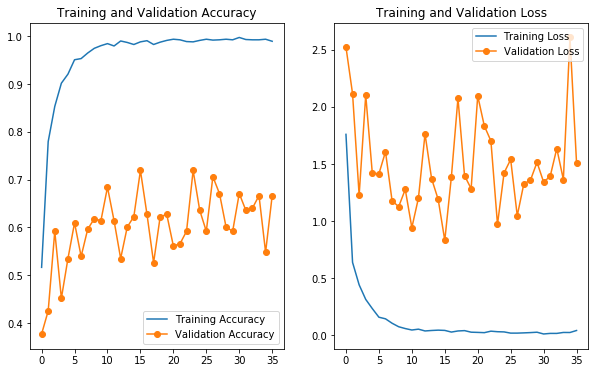

['loss', 'acc']
[0.8296787080011869, 0.7192982456140351]
[0.3466905865306948, 0.8921568639138165]


In [43]:
desc = "simple_seq"
num = 1
model = simple_seq(image_dim)

params = count_trainable(model)
print("Trainable params:", count_trainable(model))

model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer = Adam(lr=LR))

history = train_model(model,
                      train_gen,
                      val_gen,
                      f"{desc}_weights.h5",
                      0)

plot_history(history)

val_gen.reset()

print(model.metrics_names)

print(\
model.evaluate_generator(val_gen,
                         steps = int(np.ceil(val_gen.samples / BATCH_SIZE))))

test_gen.reset()
result=\
model.evaluate_generator(test_gen,
                         steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
print(result)
model_results[num] = (desc, params, result)

### With data augmentation (simple seq.)

*Note: The validation data is also augmented.*

Trainable params: 2467946

Epoch 00001: val_loss improved from inf to 2.04175, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_with_augment_weights.h5

Epoch 00002: val_loss did not improve from 2.04175

Epoch 00003: val_loss did not improve from 2.04175

Epoch 00004: val_loss improved from 2.04175 to 1.66990, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_with_augment_weights.h5

Epoch 00005: val_loss did not improve from 1.66990

Epoch 00006: val_loss did not improve from 1.66990

Epoch 00007: val_loss improved from 1.66990 to 1.08428, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_with_augment_weights.h5

Epoch 00008: val_loss did not improve from 1.08428

Epoch 00009: val_loss did not improve from 1.08428

Epoch 00010: val_loss did not improve from 1.08428

Epoch 00011: val_loss improved from 1.08428 to 0.87010, saving model to /content/gdrive/My 

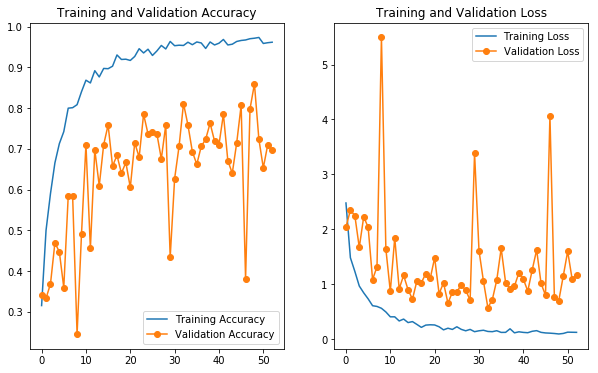

['loss', 'acc']
[0.5442870217457152, 0.8333333333333334]
[0.1765261727805231, 0.9411764694195167]


In [44]:
desc = "simple_seq_with_augment"
num = 2
model = simple_seq(image_dim)

params = count_trainable(model)
print("Trainable params:", params)

model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              optimizer = Adam(lr=LR))

history = train_model(model,
                      train_gen_augment,
                      val_gen_augment,
                      f"{desc}_weights.h5",
                      0)

plot_history(history)

val_gen_augment.reset()

print(model.metrics_names)

print(\
model.evaluate_generator(val_gen_augment,
                         steps = int(np.ceil(val_gen_augment.samples / BATCH_SIZE))))

test_gen.reset()
result\
= model.evaluate_generator(test_gen,
                           steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
print(result)

model_results[num] = (desc, params, result)

---
## MobileNet_V2 - feature-extractor
Rather that coming up with out own architecture, let's use one that was developed by someone else: here we choose the MobileNet V2.
Check the performance both with and without retraining (some of) the weights (originally trainded on *image-net*).

In [0]:
def mobile_net_v2(img_dim, retrain_fraction):
  
  MobileNetV2_ = MobileNetV2(include_top=False,
                             weights='imagenet',
                             input_shape=(img_dim, img_dim, 3))
  layer_count = len(MobileNetV2_.layers)
  for idx in range(int(layer_count * (1 - retrain_fraction))):
    MobileNetV2_.layers[idx].trainable = False

      
  x = MobileNetV2_.output
  x = GlobalMaxPooling2D()(x)
  x = Dropout(rate=0.5)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(rate=0.5)(x)
  output = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=MobileNetV2_.input, outputs=output)
  return model

In [24]:
image_dim = 128
train_gen, val_gen, train_gen_augment, val_gen_augment, test_gen = prepare_data_gens(image_dim)

Found 1630 images belonging to 10 classes.
Found 228 images belonging to 10 classes.
Found 1630 images belonging to 10 classes.
Found 228 images belonging to 10 classes.
Found 204 images belonging to 10 classes.


### No data augmentation,  retrain 10%

9412608/9406464 [==============================] - 1s 0us/step
Trainable params: 1702922
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Epoch 00001: val_loss improved from inf to 2.58599, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_10%-retrain_weights.h5

Epoch 00002: val_loss improved from 2.58599 to 1.98349, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_10%-retrain_weights.h5

Epoch 00003: val_loss improved from 1.98349 to 1.92401, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_10%-retrain_weights.h5

Epoch 00004: val_loss improved from 1.92401 to 1.68556, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_10%-retrain_weights.h5

Epoch 00005: val_loss improved from 1.68556 to 1.55115, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mo

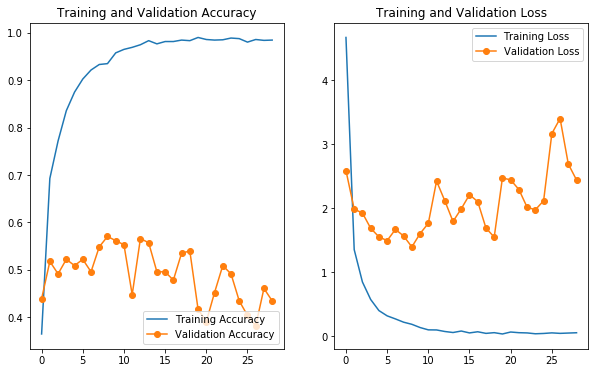

['loss', 'acc']
[1.2639926002736677, 0.6052631578947368]
[1.5537657071562374, 0.544117648227542]


In [25]:
desc = "mobilenetv2_10%-retrain"
num = 3
model = mobile_net_v2(image_dim, retrain_fraction=0.1)

params = count_trainable(model)
print("Trainable params:", params)

model.compile(optimizer=Adam(lr=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = train_model(model,
                      train_gen,
                      val_gen,
                      f"{desc}_weights.h5",
                      0)

plot_history(history)

print(model.metrics_names)

print(\
model.evaluate_generator(val_gen,
                         steps = int(np.ceil(val_gen.samples / BATCH_SIZE))))

test_gen.reset()
result\
= model.evaluate_generator(test_gen,
                           steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
print(result)
model_results[num] = (desc, params, result)

### With data augmentation, retrain 10%

*Note: The validation data is also augmented.*

Trainable params: 1702922

Epoch 00001: val_loss improved from inf to 2.14765, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_10%-retrain_with_augment_weights.h5

Epoch 00002: val_loss improved from 2.14765 to 1.79578, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_10%-retrain_with_augment_weights.h5

Epoch 00003: val_loss did not improve from 1.79578

Epoch 00004: val_loss did not improve from 1.79578

Epoch 00005: val_loss did not improve from 1.79578

Epoch 00006: val_loss improved from 1.79578 to 1.59013, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_10%-retrain_with_augment_weights.h5

Epoch 00007: val_loss did not improve from 1.59013

Epoch 00008: val_loss did not improve from 1.59013

Epoch 00009: val_loss did not improve from 1.59013

Epoch 00010: val_loss did not improve from 1.59013

Epoch 00011: val_loss did not improve from 1.59013



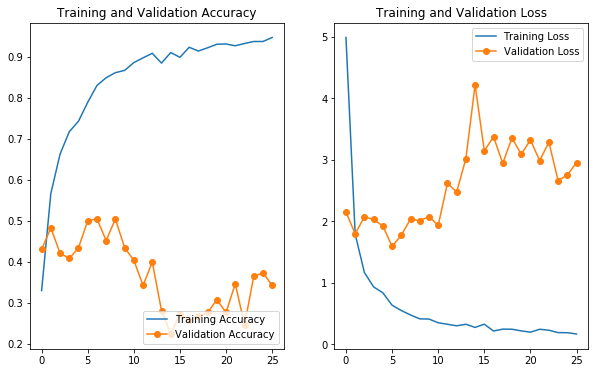

['loss', 'acc']
[1.657878980301974, 0.49122807017543857]
[1.7864892739875644, 0.5049019607843137]


In [26]:
desc = "mobilenetv2_10%-retrain_with_augment"
num = 4
model = mobile_net_v2(image_dim, retrain_fraction=0.1)

params = count_trainable(model)
print("Trainable params:", params)

model.compile(optimizer=Adam(lr=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = train_model(model,
                      train_gen_augment,
                      val_gen_augment,
                      f"{desc}_weights.h5",
                      0)

plot_history(history)

print(model.metrics_names)

print(\
model.evaluate_generator(val_gen_augment,
                         steps = int(np.ceil(val_gen_augment.samples / BATCH_SIZE))))

test_gen.reset()
result\
= model.evaluate_generator(test_gen,
                           steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
print(result)
model_results[num] = (desc, params, result)

### Without data augmentation,  retrain 90%

Trainable params: 2880458

Epoch 00001: val_loss improved from inf to 2.82592, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_90%-retrain_weights.h5

Epoch 00002: val_loss did not improve from 2.82592

Epoch 00003: val_loss did not improve from 2.82592

Epoch 00004: val_loss improved from 2.82592 to 2.80949, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_90%-retrain_weights.h5

Epoch 00005: val_loss improved from 2.80949 to 2.04215, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_90%-retrain_weights.h5

Epoch 00006: val_loss improved from 2.04215 to 1.76168, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_90%-retrain_weights.h5

Epoch 00007: val_loss improved from 1.76168 to 1.57612, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_90%-retrain_weights.h5

Epo

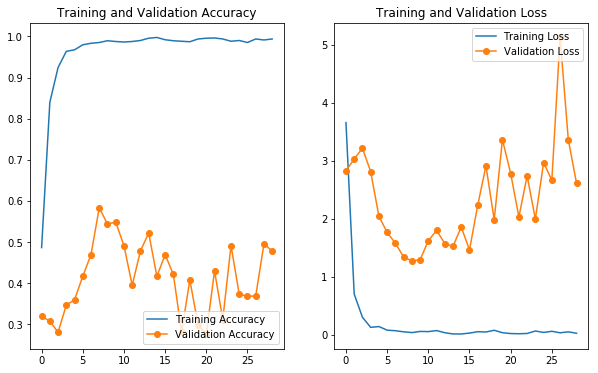

['loss', 'acc']
[1.260311015865259, 0.5482456140350878]
[0.6855839642823911, 0.8039215674587324]


In [27]:
desc = "mobilenetv2_90%-retrain"
num = 5
model = mobile_net_v2(image_dim, retrain_fraction=0.9)

params = count_trainable(model)
print("Trainable params:", params)

model.compile(optimizer=Adam(lr=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = train_model(model,
                      train_gen,
                      val_gen,
                      f"{desc}_weights.h5",
                      0)

plot_history(history)

print(model.metrics_names)

print(\
model.evaluate_generator(val_gen,
                         steps = int(np.ceil(val_gen.samples / BATCH_SIZE))))

test_gen.reset()
result\
= model.evaluate_generator(test_gen, 
                           steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
print(result)

model_results[num] = (desc, params, result)

### With data augmentation, retrain 90%

*Note: The validation data is also augmented.*

Trainable params: 2880458

Epoch 00001: val_loss improved from inf to 2.71334, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_90%-retrain_with_augment_weights.h5

Epoch 00002: val_loss improved from 2.71334 to 2.39776, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_90%-retrain_with_augment_weights.h5

Epoch 00003: val_loss improved from 2.39776 to 2.27789, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_90%-retrain_with_augment_weights.h5

Epoch 00004: val_loss did not improve from 2.27789

Epoch 00005: val_loss did not improve from 2.27789

Epoch 00006: val_loss did not improve from 2.27789

Epoch 00007: val_loss did not improve from 2.27789

Epoch 00008: val_loss did not improve from 2.27789

Epoch 00009: val_loss improved from 2.27789 to 2.04531, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_90%-re

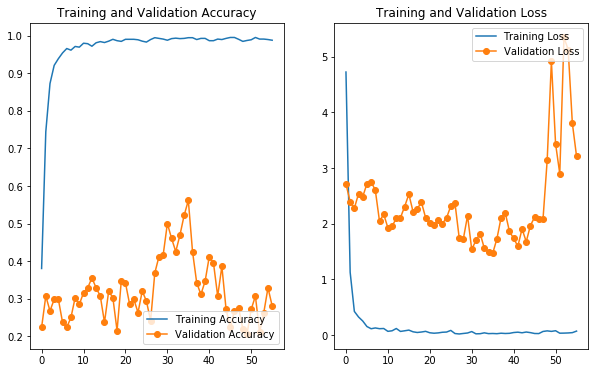

['loss', 'acc']
[1.5373940258695369, 0.5307017543859649]
[1.0335372838319516, 0.6666666678353852]


In [28]:
desc = "mobilenetv2_90%-retrain_with_augment"
num = 6
model = mobile_net_v2(image_dim, retrain_fraction=0.9)

params = count_trainable(model)
print("Trainable params:", params)

model.compile(optimizer=Adam(lr=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = train_model(model,
                      train_gen_augment,
                      val_gen_augment,
                      f"{desc}_weights.h5",
                      0)

plot_history(history)

print(model.metrics_names)

print(\
model.evaluate_generator(val_gen_augment,
                         steps = int(np.ceil(val_gen.samples / BATCH_SIZE))))

test_gen.reset()
result\
= model.evaluate_generator(test_gen,
                           steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
print(result)
model_results[num] = (desc, params, result)

### Without data augmentation,  retrain 100%
---


Trainable params: 2884874
Trainable params: 2884874

Epoch 00001: val_loss improved from inf to 1.61367, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_weights.h5

Epoch 00002: val_loss improved from 1.61367 to 0.76584, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_weights.h5

Epoch 00003: val_loss improved from 0.76584 to 0.63271, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_weights.h5

Epoch 00004: val_loss improved from 0.63271 to 0.34017, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_weights.h5

Epoch 00005: val_loss did not improve from 0.34017

Epoch 00006: val_loss improved from 0.34017 to 0.32916, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_weights.h5

Epoch 00007: val_loss did not improve from 0.32916

Epoch 00008: val_loss did not improve

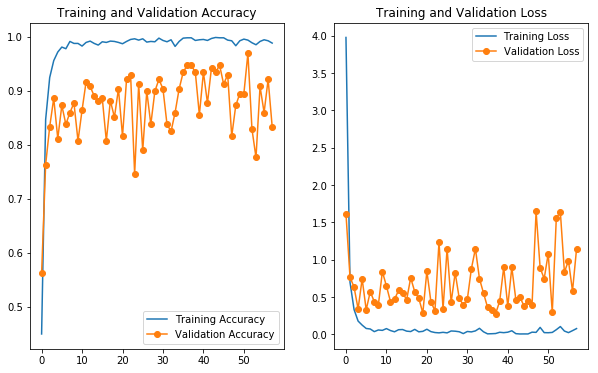

['loss', 'acc']
[0.23585426728976425, 0.9517543859649122]
[0.08277518374448427, 0.9901960784313726]


In [29]:
desc = "mobilenetv2"
num = 7
model = mobile_net_v2(image_dim, retrain_fraction=1)

params = count_trainable(model)
print("Trainable params:", params)


model.compile(optimizer=Adam(lr=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Trainable params:", count_trainable(model))

history = train_model(model,
                      train_gen,
                      val_gen,
                      f"{desc}_weights.h5",
                      0)

plot_history(history)

print(model.metrics_names)

print(\
model.evaluate_generator(val_gen,
                         steps = int(np.ceil(val_gen.samples / BATCH_SIZE))))

test_gen.reset()
result\
= model.evaluate_generator(test_gen,
                           steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
print(result)
model_results[num] = (desc, params, result)

### With data augmentation, retrain 100%

*Note: The validation data is also augmented.*

Trainable params: 2884874

Epoch 00001: val_loss improved from inf to 1.20798, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_weights.h5

Epoch 00002: val_loss improved from 1.20798 to 0.67597, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_weights.h5

Epoch 00003: val_loss did not improve from 0.67597

Epoch 00004: val_loss did not improve from 0.67597

Epoch 00005: val_loss improved from 0.67597 to 0.44466, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_weights.h5

Epoch 00006: val_loss improved from 0.44466 to 0.30080, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_weights.h5

Epoch 00007: val_loss improved from 0.30080 to 0.28586, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/mobilenetv2_with_augment_weights.h5

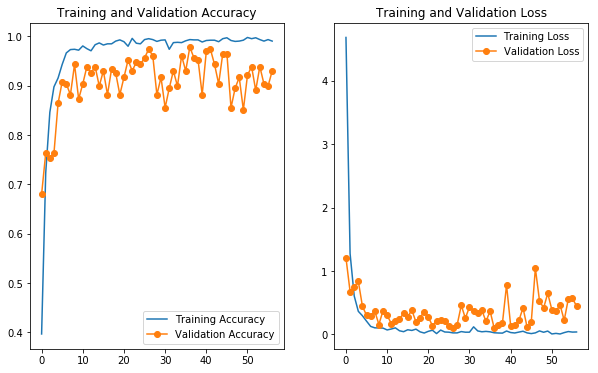

['loss', 'acc']
[0.14019726978244362, 0.9692982456140351]
[0.18184036024225256, 0.9803921568627451]


In [30]:
desc = "mobilenetv2_with_augment"
num = 8
model = mobile_net_v2(image_dim,
                      retrain_fraction=1)

params = count_trainable(model)
print("Trainable params:", params)

model.compile(optimizer=Adam(lr=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = train_model(model,
                      train_gen_augment,
                      val_gen_augment,
                      f"{desc}_weights.h5",
                      0)

plot_history(history)

print(model.metrics_names)

print(\
model.evaluate_generator(val_gen_augment,
                         steps = int(np.ceil(val_gen.samples / BATCH_SIZE))))

test_gen.reset()
result\
= model.evaluate_generator(test_gen,
                           steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
print(result)
model_results[num] = (desc, params, result)

---
We have seen that weights trained on ImageNet are not helpful in our problem.

Still, the results of fully retrained MobileNet seem a bit buffling: they do not become better when data augmentation is applied. The exact augmentation is defined above, and it rather isn't very agressive.

So, let's take two other predifined architectures:
* DenseNet,
* ImageNet,

both with and without data augmentation, and see how they behave.

This time we will stick to the original size of the images: 100 x 100, which is generally smaller than what those architectures were originally geared for, and retrain the whole network starting from random weights.


In [31]:
image_dim = 100
train_gen, val_gen, train_gen_augment, val_gen_augment, test_gen = prepare_data_gens(image_dim)

Found 1630 images belonging to 10 classes.
Found 228 images belonging to 10 classes.
Found 1630 images belonging to 10 classes.
Found 228 images belonging to 10 classes.
Found 204 images belonging to 10 classes.


---

DenseNet121

In [0]:
def densenet(img_dim):
  
  DenseNet121_ = DenseNet121(include_top=False,
                               weights=None, #'imagenet',
                               input_shape=(img_dim, img_dim, 3))
  
  x = DenseNet121_.output
  x = GlobalMaxPooling2D()(x)
  x = Dropout(rate=0.5)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(rate=0.5)(x)
  output = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=DenseNet121_.input, outputs=output)
  return model

Trainable params: 7483786

Epoch 00001: val_loss improved from inf to 3.76248, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/densenet_retrain_whole_weights.h5

Epoch 00002: val_loss improved from 3.76248 to 2.83692, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/densenet_retrain_whole_weights.h5

Epoch 00003: val_loss did not improve from 2.83692

Epoch 00004: val_loss did not improve from 2.83692

Epoch 00005: val_loss did not improve from 2.83692

Epoch 00006: val_loss did not improve from 2.83692

Epoch 00007: val_loss did not improve from 2.83692

Epoch 00008: val_loss did not improve from 2.83692

Epoch 00009: val_loss did not improve from 2.83692

Epoch 00010: val_loss did not improve from 2.83692

Epoch 00011: val_loss improved from 2.83692 to 2.72693, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/densenet_retrain_whole_weights.h5

Epoch 00012: val_loss improved from 2.7269

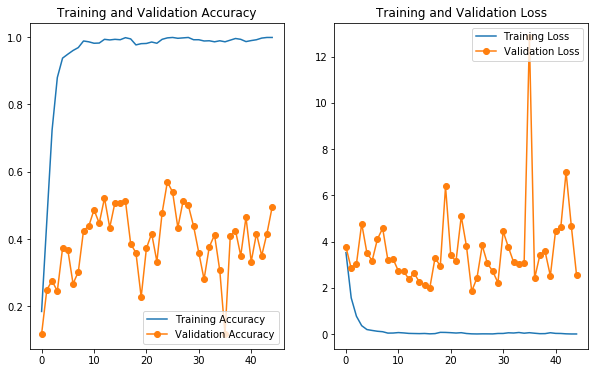

['loss', 'acc']
[2.0056346592150236, 0.5350877192982456]
[0.4262323993093827, 0.8823529400077521]


In [33]:
desc = "densenet_retrain_whole"
num = 9
model = densenet(image_dim)

params = count_trainable(model)
print("Trainable params:", count_trainable(model))

model.compile(optimizer=Adam(lr=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = train_model(model,
                      train_gen,
                      val_gen,
                      f"{desc}_weights.h5",
                      0)

plot_history(history)

print(model.metrics_names)

print(\
model.evaluate_generator(val_gen,
                         steps = int(np.ceil(val_gen.samples / BATCH_SIZE))))

test_gen.reset()
result\
= model.evaluate_generator(test_gen,
                           steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
print(result)
model_results[num] = (desc, params, result)

Trainable params: 7483786

Epoch 00001: val_loss improved from inf to 10.22429, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/densenet_with_augment_retrain_whole_weights.h5

Epoch 00002: val_loss improved from 10.22429 to 2.27802, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/densenet_with_augment_retrain_whole_weights.h5

Epoch 00003: val_loss did not improve from 2.27802

Epoch 00004: val_loss did not improve from 2.27802

Epoch 00005: val_loss improved from 2.27802 to 2.01676, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/densenet_with_augment_retrain_whole_weights.h5

Epoch 00006: val_loss did not improve from 2.01676

Epoch 00007: val_loss did not improve from 2.01676

Epoch 00008: val_loss improved from 2.01676 to 1.53842, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/densenet_with_augment_retrain_whole_weights.h5

Epoch 00009: val_loss d

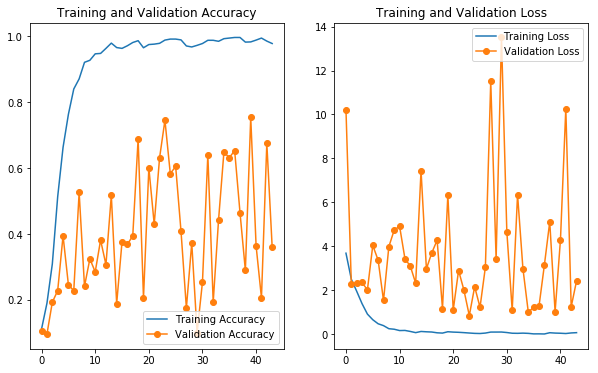

['loss', 'acc']
[0.9374479797848484, 0.706140350877193]
[0.49347035148564505, 0.8382352929489285]


In [34]:
desc = "densenet_with_augment_retrain_whole"
num = 10
model = densenet(image_dim)

params = count_trainable(model)
print("Trainable params:", params)

model.compile(optimizer=Adam(lr=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = train_model(model,
                      train_gen_augment,
                      val_gen_augment,
                      f"{desc}_weights.h5",
                      0)

plot_history(history)

print(model.metrics_names)

print(\
model.evaluate_generator(val_gen_augment,
                         steps = int(np.ceil(val_gen.samples / BATCH_SIZE))))

test_gen.reset()
result\
= model.evaluate_generator(test_gen,
                           steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
print(result)
model_results[num] = (desc, params, result)

---
Xception

In [0]:
def xception(img_dim):
  
  Xception_ = Xception(include_top=False,
                       weights=None, #'imagenet',
                       input_shape=(img_dim, img_dim, 3))
  
  x = Xception_.output
  x = GlobalMaxPooling2D()(x)
  x = Dropout(rate=0.5)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(rate=0.5)(x)
  output = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=Xception_.input, outputs=output)
  return model

Trainable params: 21861170

Epoch 00001: val_loss improved from inf to 3.06246, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/xception_retrain_whole_weights.h5

Epoch 00002: val_loss improved from 3.06246 to 2.24071, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/xception_retrain_whole_weights.h5

Epoch 00003: val_loss did not improve from 2.24071

Epoch 00004: val_loss did not improve from 2.24071

Epoch 00005: val_loss did not improve from 2.24071

Epoch 00006: val_loss improved from 2.24071 to 2.06616, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/xception_retrain_whole_weights.h5

Epoch 00007: val_loss did not improve from 2.06616

Epoch 00008: val_loss improved from 2.06616 to 1.32421, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/xception_retrain_whole_weights.h5

Epoch 00009: val_loss did not improve from 1.32421

Epoch 00010: val_loss di

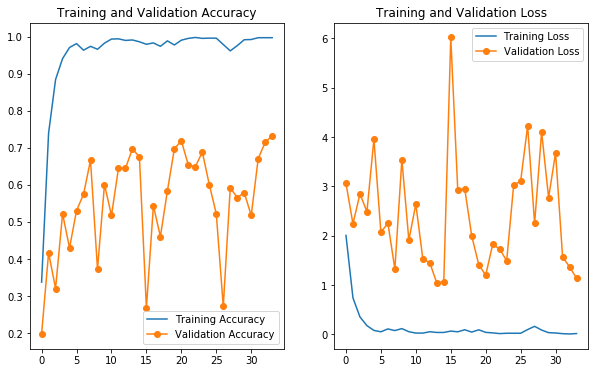

['loss', 'acc']
[0.9416757497871131, 0.7192982456140351]
[0.4941598270453659, 0.8725490207765617]


In [36]:
desc = "xception_retrain_whole"
num = 11
model = xception(image_dim)

params = count_trainable(model)
print("Trainable params:", params)

model.compile(optimizer=Adam(lr=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = train_model(model,
                      train_gen,
                      val_gen,
                      f"{desc}_weights.h5",
                      0)

plot_history(history)

print(model.metrics_names)

print(\
model.evaluate_generator(val_gen,
                         steps = int(np.ceil(val_gen.samples / BATCH_SIZE))))

test_gen.reset()
result\
= model.evaluate_generator(test_gen,
                             steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
print(result)
model_results[num] = (desc, params, result)

Trainable params: 21861170

Epoch 00001: val_loss improved from inf to 2.30771, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/xception_with_augment_retrain_whole_weights.h5

Epoch 00002: val_loss improved from 2.30771 to 1.68978, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/xception_with_augment_retrain_whole_weights.h5

Epoch 00003: val_loss did not improve from 1.68978

Epoch 00004: val_loss did not improve from 1.68978

Epoch 00005: val_loss did not improve from 1.68978

Epoch 00006: val_loss did not improve from 1.68978

Epoch 00007: val_loss did not improve from 1.68978

Epoch 00008: val_loss improved from 1.68978 to 1.00978, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/xception_with_augment_retrain_whole_weights.h5

Epoch 00009: val_loss improved from 1.00978 to 0.74542, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/xception_with_augmen

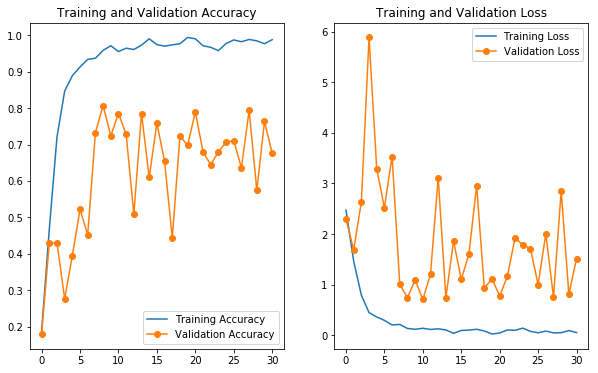

['loss', 'acc']
[0.6519674360098546, 0.8245614035087719]
[0.3357366554292978, 0.9313725501883263]


In [37]:
desc = "xception_with_augment_retrain_whole"
num = 12
model = xception(image_dim)

params = count_trainable(model)
print("Trainable params:", params)

model.compile(optimizer=Adam(lr=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = train_model(model,
                      train_gen_augment,
                      val_gen_augment,
                      f"{desc}_weights.h5",
                      0)

plot_history(history)

print(model.metrics_names)

print(\
model.evaluate_generator(val_gen_augment,
                         steps = int(np.ceil(val_gen.samples / BATCH_SIZE))))

test_gen.reset()
result\
= model.evaluate_generator(test_gen,
                           steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))
print(result)
model_results[num] = (desc, params, result)

## Summary

In [0]:
final_results\
=\
pd.DataFrame(\
 np.array([[desc, params, loss, acc] for (key, (desc, params, (loss, acc))) in model_results.items()]).reshape(-1, 4),\
 columns = ['desc', 'params', 'loss', 'acc'], index = model_results.keys()
)

In [46]:
final_results

,desc,params,loss,acc
1,simple_seq,2467946,0.3466905865306948,0.8921568639138165
2,simple_seq_with_augment,2467946,0.1765261727805231,0.9411764694195167
3,mobilenetv2_10%-retrain,1702922,1.5537657071562374,0.544117648227542
4,mobilenetv2_10%-retrain_with_augment,1702922,1.7864892739875644,0.5049019607843137
5,mobilenetv2_90%-retrain,2880458,0.6855839642823911,0.8039215674587324
6,mobilenetv2_90%-retrain_with_augment,2880458,1.0335372838319516,0.6666666678353852
7,mobilenetv2,2884874,0.08277518374448427,0.9901960784313726
8,mobilenetv2_with_augment,2884874,0.18184036024225256,0.9803921568627451
9,densenet_retrain_whole,7483786,0.4262323993093827,0.8823529400077521
10,densenet_with_augment_retrain_whole,7483786,0.49347035148564505,0.8382352929489285
